In [1]:
!python -m pip install -e . >> /dev/null

In [2]:
import toolviper
import xradio
import pathlib
import numba
import calviper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xradio import measurement_set as ms

In [3]:
if not pathlib.Path.cwd().joinpath("data/gaincaltest2.ps.zarr").exists():
    toolviper.utils.data.download("gaincal.test.zarr", "data")

In [4]:
ps = ms.open_processing_set("data/gaincaltest2.ps.zarr")

sub_ps = ps.sel(intents="CALIBRATE_DELAY#ON_SOURCE", scan_number=2)
sub_ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
1,gaincaltest2_0,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_1#SW-01#FULL_RES_0,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.607155e+10,8.629030e+10
0,gaincaltest2_2,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_2#SW-01#FULL_RES_1,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",8.794655e+10,8.816530e+10
3,gaincaltest2_4,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_3#SW-01#FULL_RES_2,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.632156e+10,9.654030e+10
2,gaincaltest2_6,"[CALIBRATE_DELAY#ON_SOURCE, CALIBRATE_PHASE#ON...","(957, 45, 8, 4)","[XX, XY, YX, YY]","[2, 4, 6, 9, 11, 14, 16, 18, 21, 23, 26]",X0000000000#ALMA_RB_03#BB_4#SW-01#FULL_RES_3,[J2255-3500_0],[J2255-3500_0],[],"[icrs, 22h55m57.68s, -35d00m00.00s]",9.819656e+10,9.841530e+10


In [5]:
dataset = sub_ps["gaincaltest2_0"]
dataset.VISIBILITY.values[0, 0, 0, ...]

array([9.6460044e-01+0.0123581j , 9.4675638e-02+0.10904321j,
       9.7834389e-04-0.16079032j, 9.8994035e-01+0.2508412j ],
      dtype=complex64)

In [6]:
dataset.VISIBILITY.values.reshape(957, 45, 8, 2, 2)[0, 0, 0, ...]

array([[9.6460044e-01+0.0123581j , 9.4675638e-02+0.10904321j],
       [9.7834389e-04-0.16079032j, 9.8994035e-01+0.2508412j ]],
      dtype=complex64)

In [7]:
V = dataset.VISIBILITY.mean(dim=["time", "frequency"], keepdims=True, keep_attrs=True).data.compute()
V.shape

(1, 45, 1, 4)

In [8]:
cm = calviper.factory.jones.CalibrationMatrix()

In [9]:
G = cm.create_jones("gain").empty_like(dataset)

[2025-02-14 19:20:21,447]     INFO    viperlog:  Module path: /home/mystletainn/Development/calviper/src/calviper 


In [10]:
G.gain.initialize()

In [11]:
G

<xarray.Dataset> Size: 15MB
Dimensions:       (time: 957, antenna: 10, frequency: 8, polarization: 2,
                   scan_id: 957, baseline_id: 45, p: 2, q: 2)
Coordinates:
  * time          (time) float64 8kB 1.503e+09 1.503e+09 ... 1.503e+09 1.503e+09
  * antenna       (antenna) <U9 360B 'DA41_A110' 'DA42_A123' ... 'DA50_A108'
  * frequency     (frequency) float64 64B 8.607e+10 8.61e+10 ... 8.629e+10
  * polarization  (polarization) <U1 8B 'X' 'Y'
  * scan_id       (scan_id) int64 8kB 2 2 2 2 2 2 2 2 ... 26 26 26 26 26 26 26
  * baseline_id   (baseline_id) int64 360B 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
Dimensions without coordinates: p, q
Data variables:
    PARAMETER     (time, antenna, frequency, polarization) float64 1MB nan .....
    WEIGHT        (time, antenna, frequency, polarization) float64 1MB 0.0 .....
    FLAG          (time, antenna, frequency, polarization) float64 1MB 0.0 .....
    MATRIX        (time, baseline_id, frequency, p, q) complex64 11MB (1+0j) ...
Attributes:
    calibration_type:  gain
    observation_info:  {'observer': ['lknee'], 'project': 'uid://A002/X1f841f...

In [12]:
G.PARAMETER.shape

(957, 10, 8, 2)

In [13]:
G.coords.items()

ItemsView(Coordinates:
  * time          (time) float64 8kB 1.503e+09 1.503e+09 ... 1.503e+09 1.503e+09
  * antenna       (antenna) <U9 360B 'DA41_A110' 'DA42_A123' ... 'DA50_A108'
  * frequency     (frequency) float64 64B 8.607e+10 8.61e+10 ... 8.629e+10
  * polarization  (polarization) <U1 8B 'X' 'Y'
  * scan_id       (scan_id) int64 8kB 2 2 2 2 2 2 2 2 ... 26 26 26 26 26 26 26
  * baseline_id   (baseline_id) int64 360B 0 1 2 3 4 5 6 ... 39 40 41 42 43 44)

In [14]:
v = V

full_antenna_list = np.union1d(
    dataset.baseline_antenna1_name.to_numpy(),
    dataset.baseline_antenna2_name.to_numpy()
)

full_antenna_list

encoder, antennas = calviper.math.tools.encode(full_antenna_list)

index_a = encoder.transform(dataset.baseline_antenna1_name.to_numpy())
index_b = encoder.transform(dataset.baseline_antenna2_name.to_numpy())

v_ = calviper.math.tools.build_visibility_matrix(array=v, index_a=index_a, index_b=index_b)

In [15]:
v.shape

(1, 45, 1, 4)

In [16]:
v_.shape

(1, 1, 4, 10, 10)

In [17]:
solver = calviper.math.solver.least_squares.LeastSquaresSolver()

In [21]:
gain_solutions = solver.solve(
    vis=v_,
    iterations=4,
    optimizer=calviper.math.optimizer.MeanSquaredError(alpha=0.25),
    stopping=1e-4
)

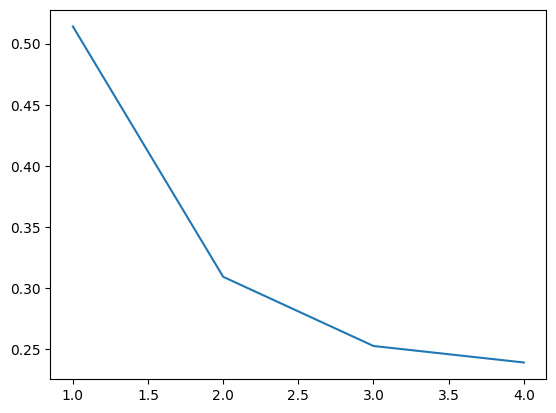

In [22]:
t = np.linspace(1, len(solver.losses), len(solver.losses))

plt.plot(t, solver.losses)

In [23]:
# Gain solutions

print(f"X: {np.abs(solver.parameter[..., 0, :])}")
print(f"Y: {np.abs(solver.parameter[..., 1, :])}")

X: [[[1.07793959 0.87037631 0.97883375 0.77607375 0.88557294 0.86207577
   1.05978381 0.90815567 0.81068105 0.92313125]]]
Y: [[[0.99018288 0.91463778 0.83269097 0.96802536 0.91673303 1.03103339
   0.58720071 0.95591083 0.68677985 0.74902333]]]


In [ ]:
#solver.parameter.shape

In [ ]:
import pandas as pd

df = pd.read_csv("reference_gains_scan_2.csv", delimiter=",")

In [ ]:
for value in df[0:10]:
    print(value)

In [ ]:
model_ = (1.0 + 1j * 0.0) * np.ones_like(v_, dtype=np.complex64)

# numpy.fill_diagonal doesn't fill tensors in the way I had hoped, ie. for shape = (m, n, i, j)
# the fill is done for m == n == i == j, which is not what we want. Instead, we want
# i == j for each (m. n). The following is my attempt to fix this.
eye = np.identity(10, dtype=np.complex64)
#np.fill_diagonal(anti_eye, np.complex64(0., 0.))

model_ = model_ * eye

In [ ]:
#for i in range(10):
    #print(model_[0, 0, 1, i, :])

In [ ]:
import numpy as np

model = np.random.uniform(low=0.0, high=1.0, size=model_.shape)

In [ ]:
model[0, 0, 0, ...]